In [1]:
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%time
!git clone https://github.com/ultralytics/yolov5 
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt 
!cp yolov5/requirements.txt ./

Cloning into 'yolov5'...
remote: Enumerating objects: 16977, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 16977 (delta 89), reused 110 (delta 54), pack-reused 16805 (from 1)
Receiving objects: 100% (16977/16977), 15.71 MiB | 20.11 MiB/s, done.
Resolving deltas: 100% (11627/11627), done.
     |████████████████████████████████| 403 kB 21.3 MB/s            
ERROR: Could not find a version that satisfies the requirement numpy>=1.23.5 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5,

In [3]:
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv('../input/car-object-detection/data/train_solution_bounding_boxes (1).csv')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
print(df.head())

      image_id        xmin        ymin        xmax        ymax
0   vid_4_1000  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060   16.630970  186.546010  132.558611  238.386422


In [4]:
df['x_center'] = (df['xmin'] + df['xmax'])/2

In [5]:
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

image_id        xmin        ymin        xmax        ymax  x_center  \
0   vid_4_1000  281.259045  187.035071  327.727931  223.225547  0.450434   
1  vid_4_10000   15.163531  187.035071  120.329957  236.430180  0.100217   
2  vid_4_10040  239.192475  176.764801  361.968162  236.430180  0.444645   
3  vid_4_10020  496.483358  172.363256  630.020260  231.539575  0.833213   
4  vid_4_10060   16.630970  186.546010  132.558611  238.386422  0.110347   

   y_center         w         h  classes  
0  0.539817  0.068741  0.095238        0  
1  0.557191  0.155572  0.129987        0  
2  0.543678  0.181621  0.157014        0  
3  0.531451  0.197540  0.155727        0  
4  0.559122  0.171491  0.136422        0

In [6]:
index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'/kaggle/input/car-object-detection/data/training_images/{image}.jpg')
img.shape

Image ID: vid_4_620


(380, 676, 3)

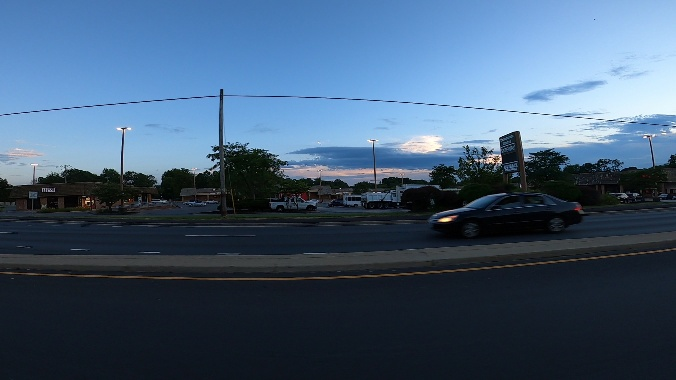

In [7]:
image = random.choice(index)
Image(filename=f'/kaggle/input/car-object-detection/data/training_images/{image}.jpg',width=600)

## Training the model


In [8]:
source = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('data/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('data/fold{}/labels/'.format(fold)+path2save)
            with open('data/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('data/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('data/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/kaggle/input/car-object-detection/data/{}/{}.jpg".format(source,name),'data/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

  0%|          | 0/355 [00:00<?, ?it/s]

In [9]:
#!ls data/fold0/images/train2017

In [10]:
%%writefile dataset.yaml
path: ../data/fold0/
train: images/train2017
val: images/val2017 
test: 
names:
  0: car

Writing dataset.yaml


In [11]:
!python yolov5/train.py --batch 12 --epochs 12 --data dataset.yaml --weights yolov5s.pt --name yolov5x_fold0_new

     |████████████████████████████████| 616 kB 18.6 MB/s            
     |████████████████████████████████| 62.5 MB 60 kB/s              
     |████████████████████████████████| 614 kB 45.3 MB/s            
     |████████████████████████████████| 614 kB 46.4 MB/s            
     |████████████████████████████████| 606 kB 60.7 MB/s            
     |████████████████████████████████| 606 kB 55.7 MB/s            
     |████████████████████████████████| 605 kB 32.7 MB/s            
     |████████████████████████████████| 605 kB 49.4 MB/s            
     |████████████████████████████████| 78 kB 5.9 MB/s             
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.62.3
    Uninstalling tqdm-4.62.3:
      Successfully uninstalled tqdm-4.62.3
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60
ERROR: pip's dependency resolver does not c

## Stats

In [12]:
!ls yolov5/runs/train/yolov5x_fold0_new/weights/

best.pt  last.pt


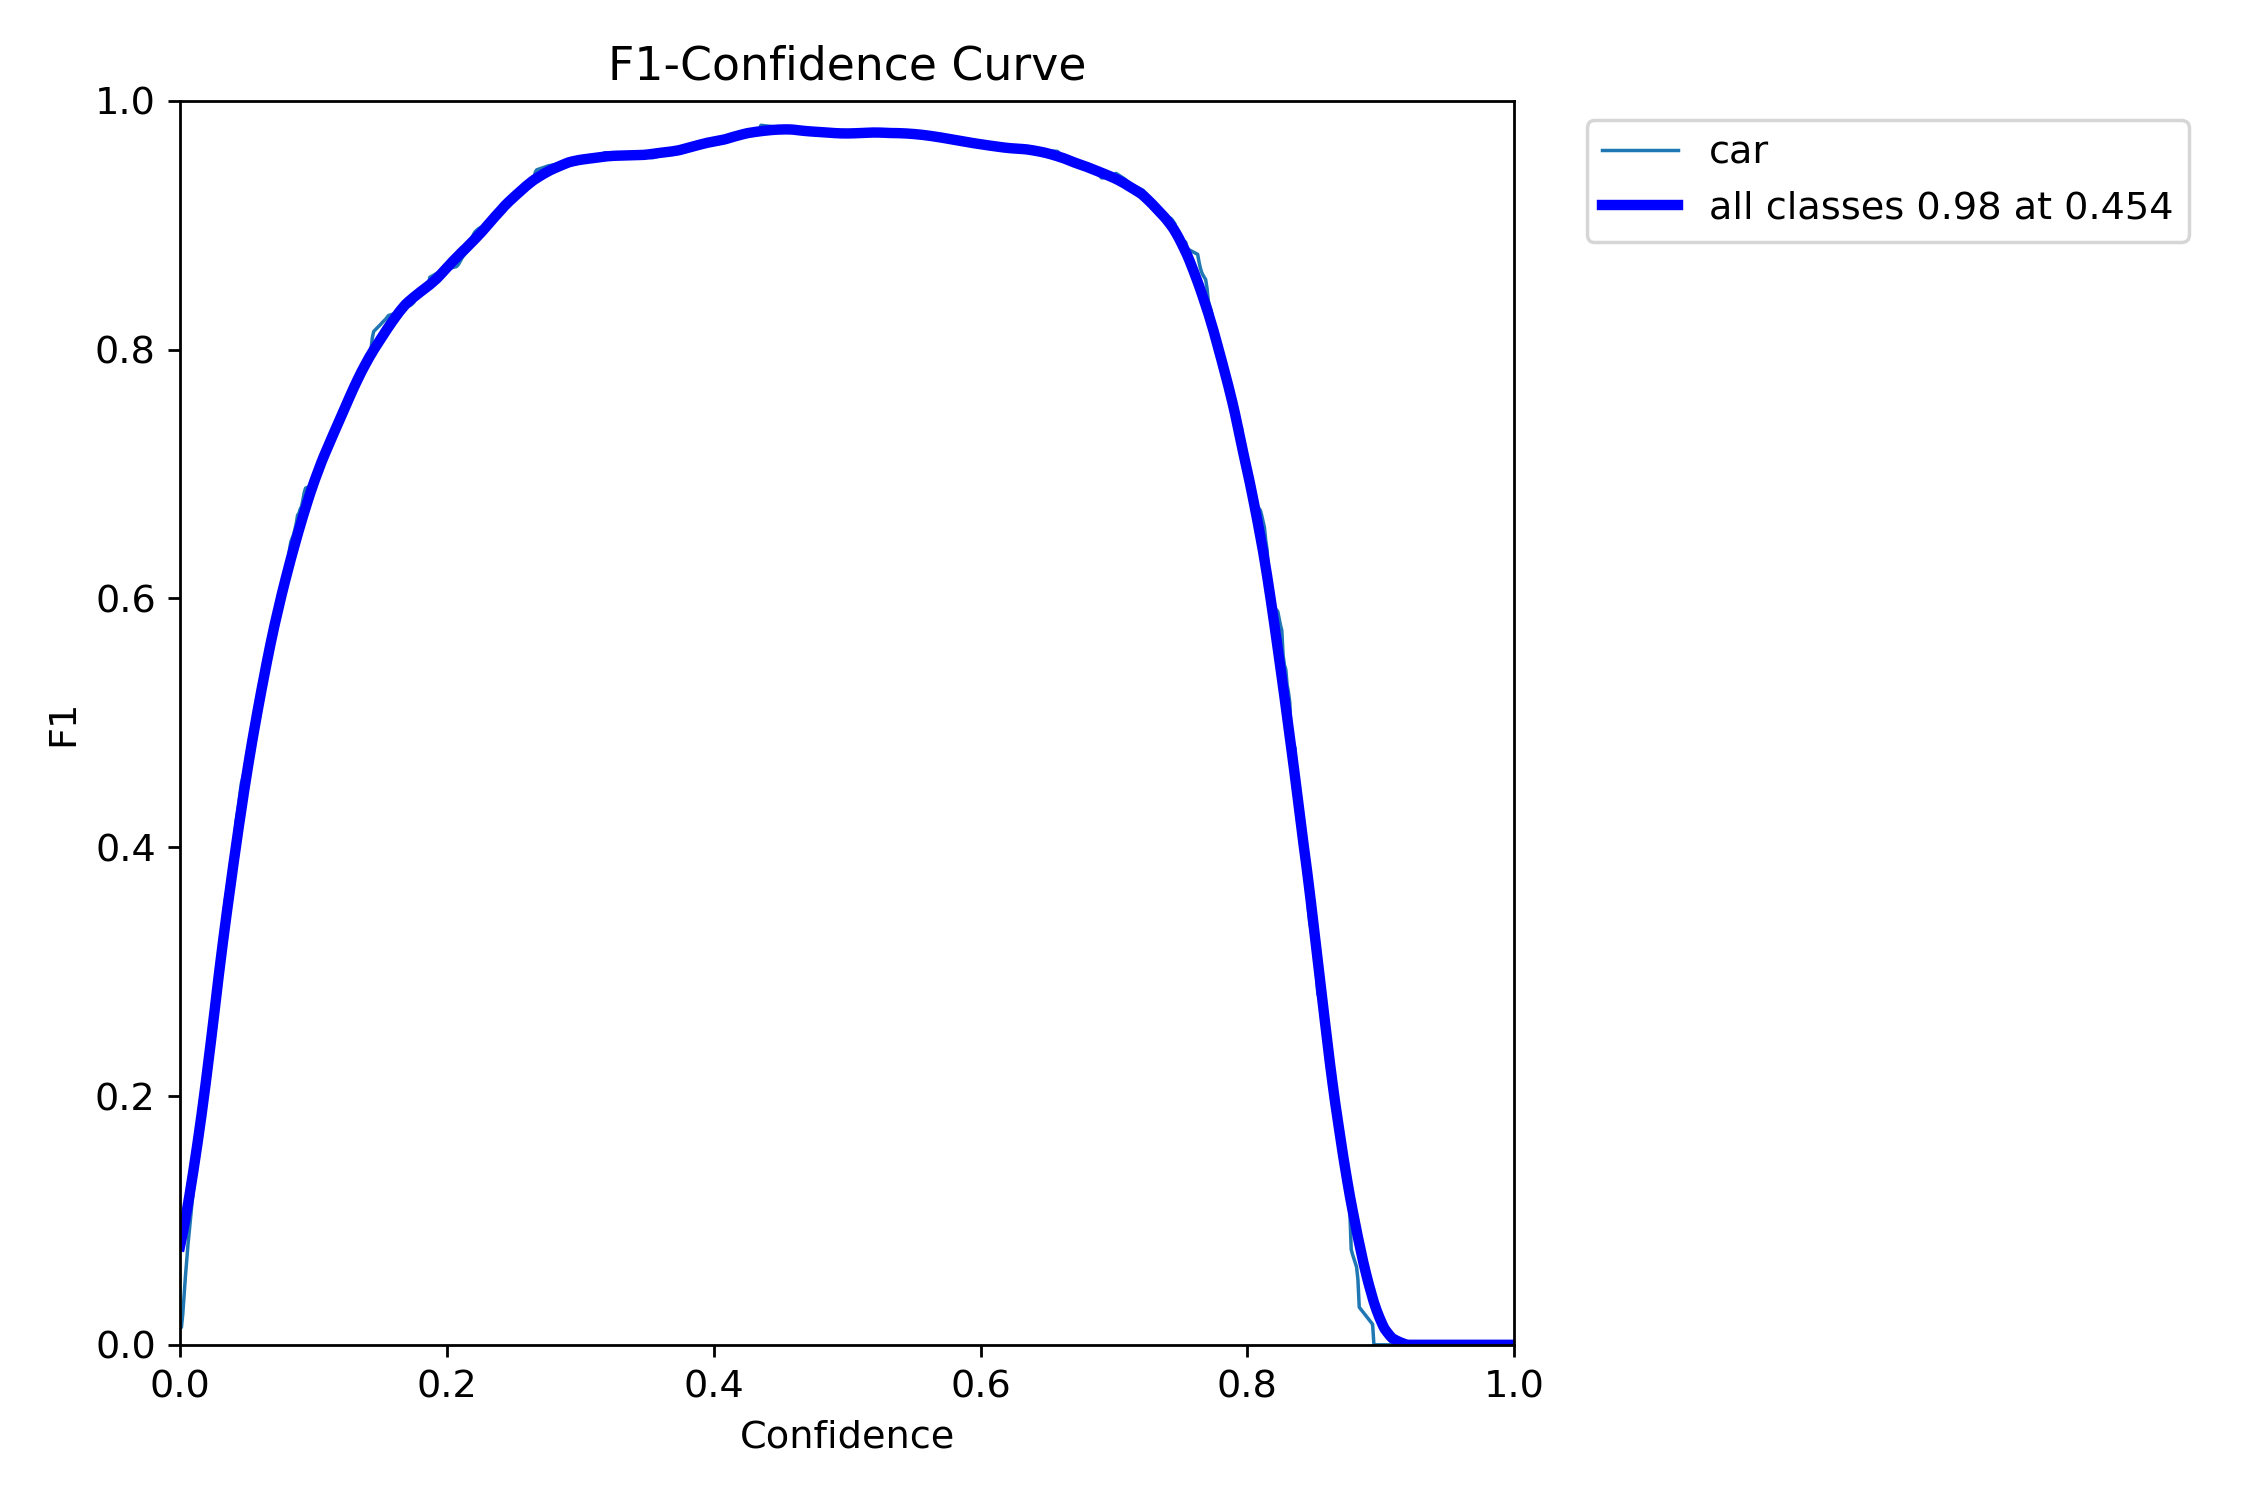

In [13]:
from PIL import Image
Image.open("yolov5/runs/train/yolov5x_fold0_new/F1_curve.png")

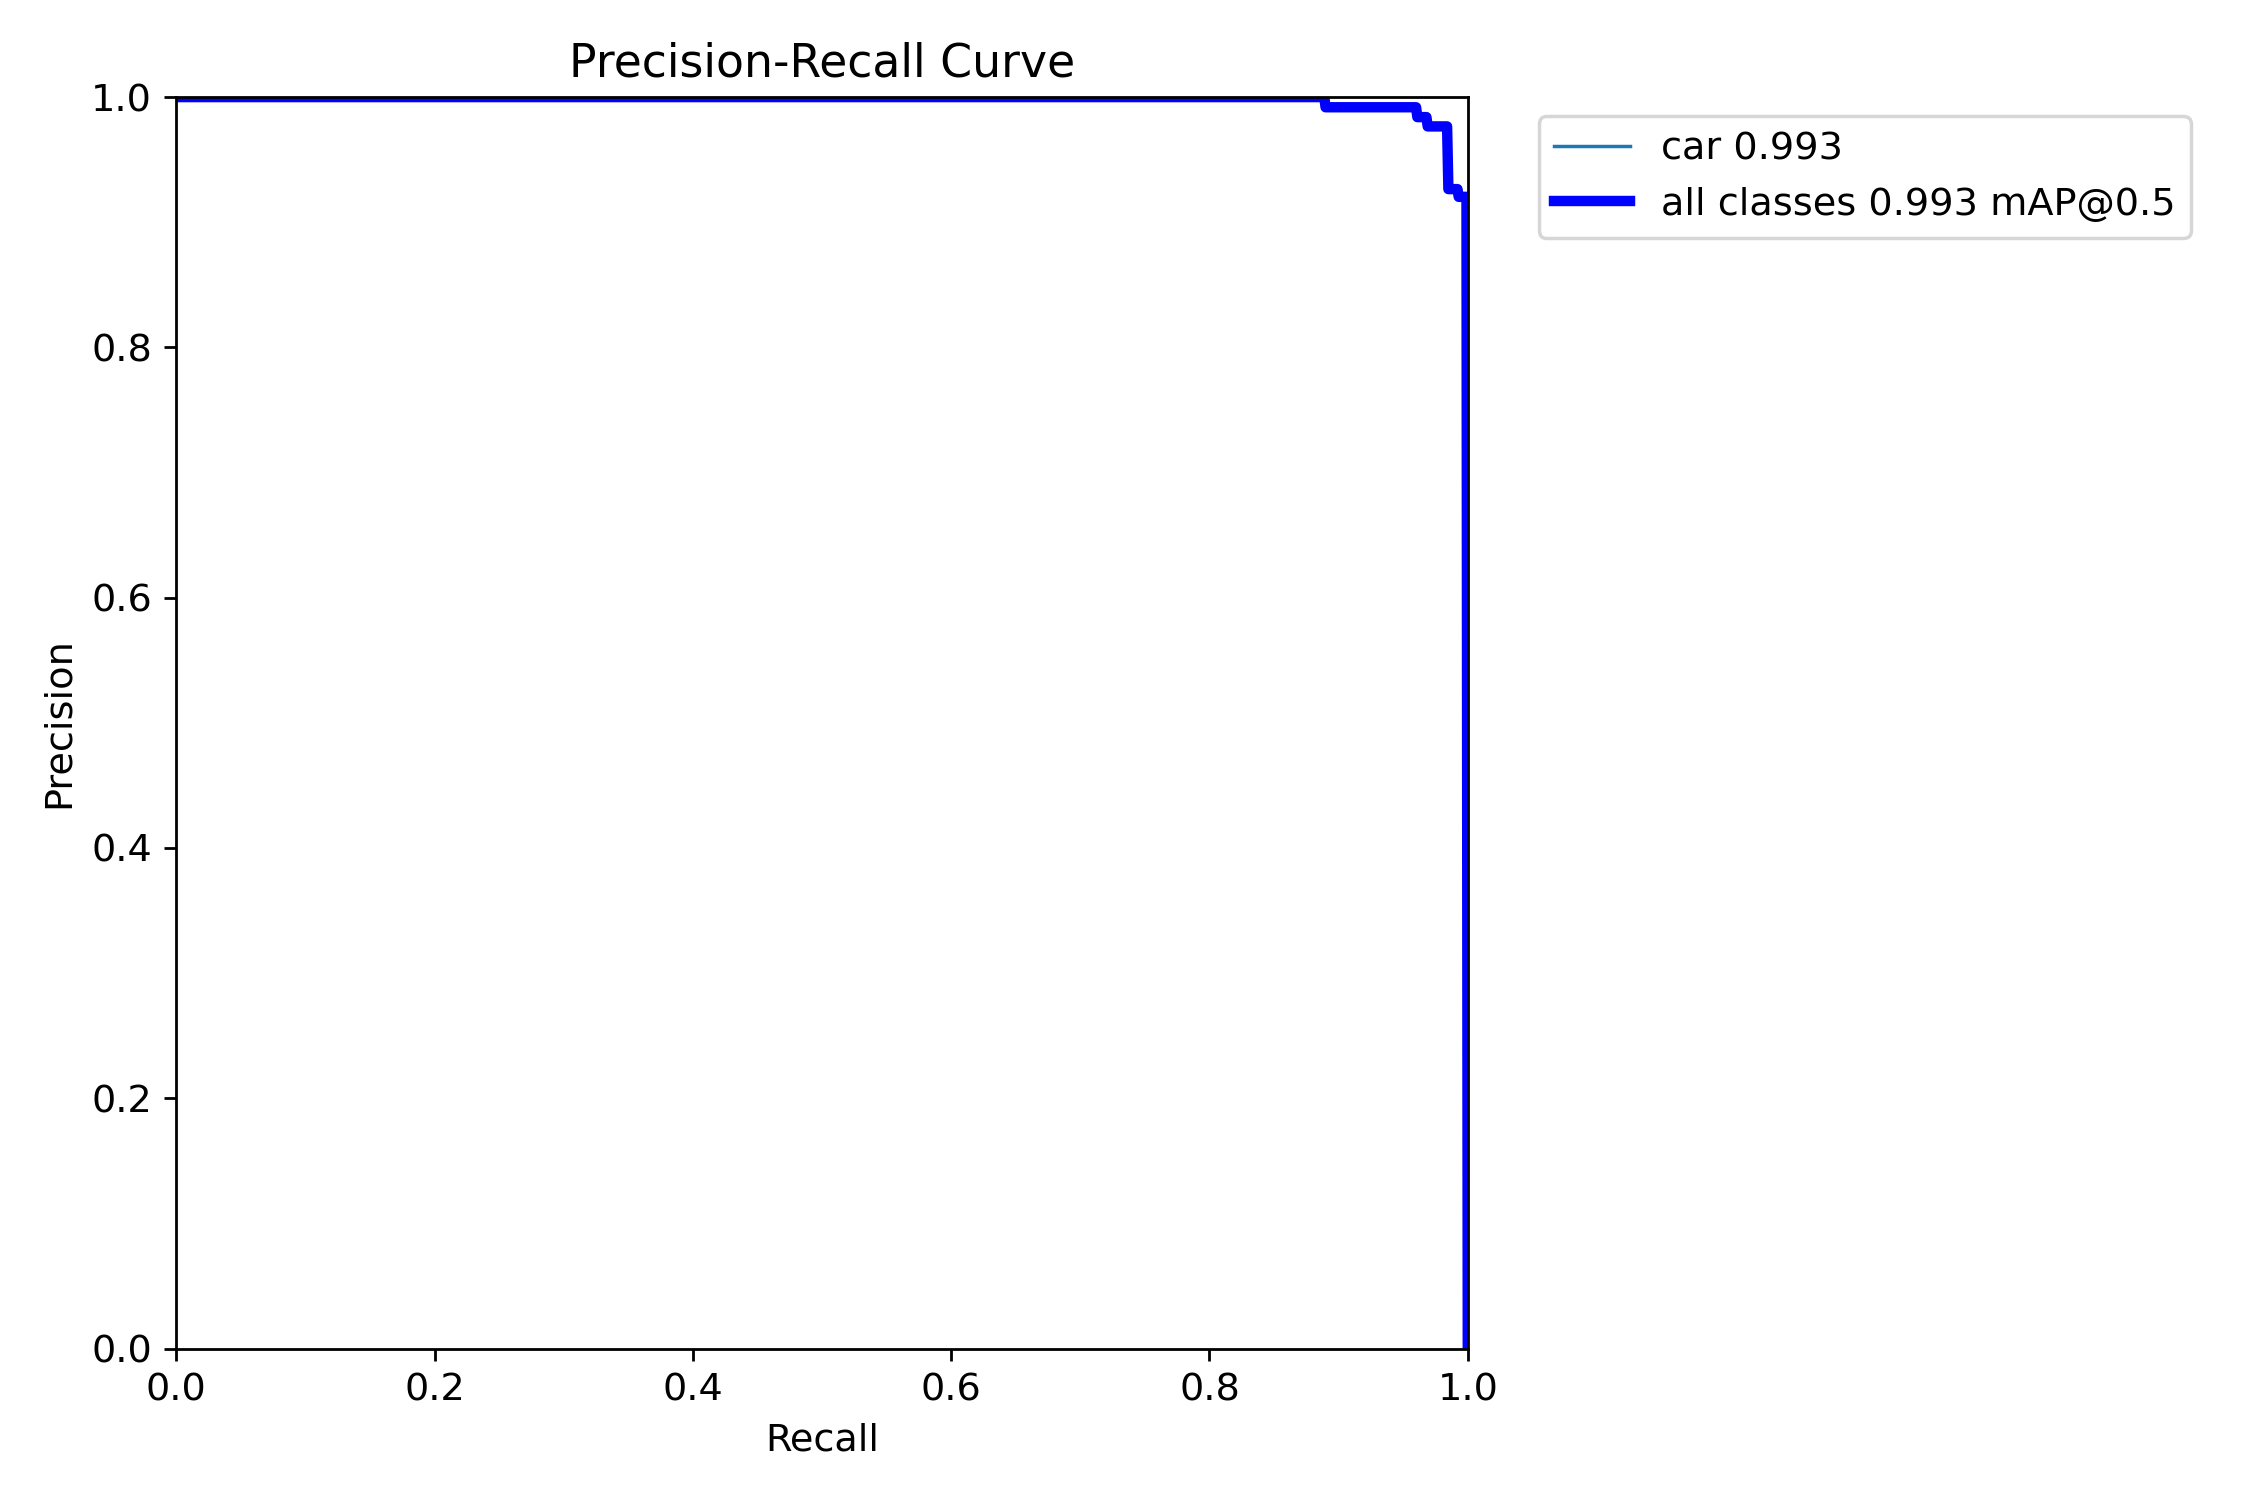

In [14]:
Image.open("yolov5/runs/train/yolov5x_fold0_new/PR_curve.png")

## Prediction

In [15]:
!python yolov5/detect.py --weights yolov5/runs/train/yolov5x_fold0_new/weights/best.pt --img 676 --conf 0.6 --source /kaggle/input/car-object-detection/data/testing_images

detect: weights=['yolov5/runs/train/yolov5x_fold0_new/weights/best.pt'], source=/kaggle/input/car-object-detection/data/testing_images, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: Ultralytics requirements ['gitpython>=3.1.30', 'pillow>=10.3.0'] not found, attempting AutoUpdate...
ERROR: Could not find a version that satisfies the requirement pillow>=10.3.0 (from versions: 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7.0, 1.7.1, 1.7.2, 1.7.3, 1.7.4, 1.7.5, 1.7.6, 1.7.7, 1.7.8, 2.0.0, 2.1.0, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.3.2, 2.4.0, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.7.0,

In [16]:
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("./yolov5/runs/detect/exp"):
    predicted_files.extend(filenames)

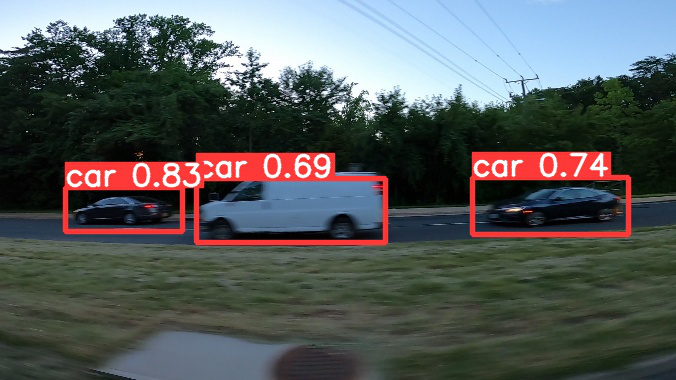

In [17]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')

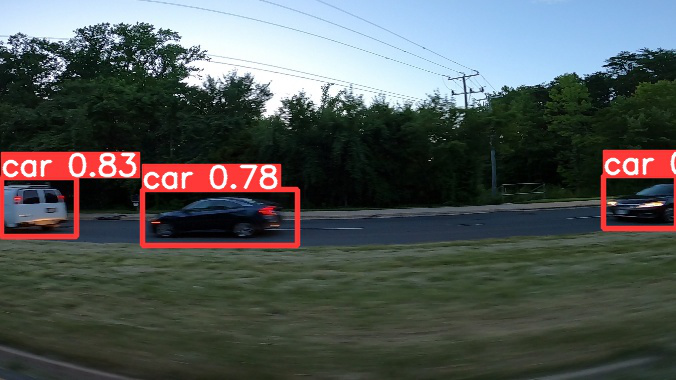

In [18]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')

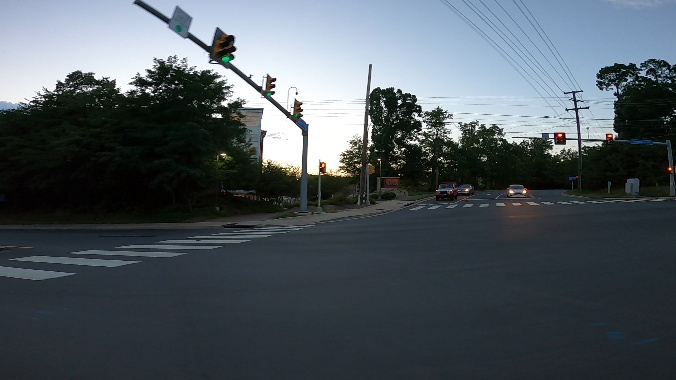

In [19]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')

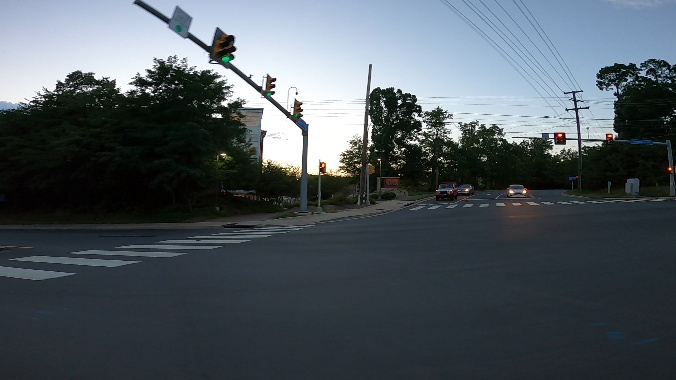

In [20]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')

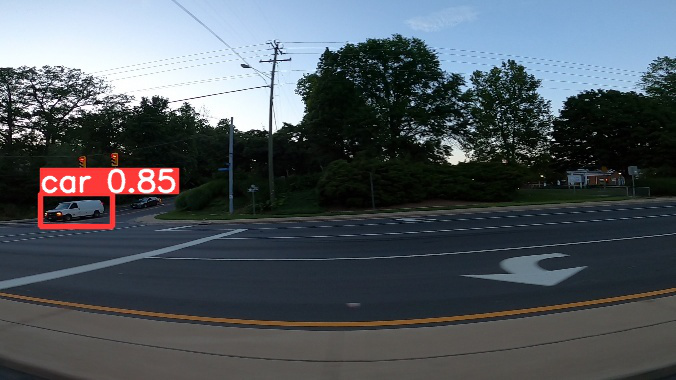

In [21]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')

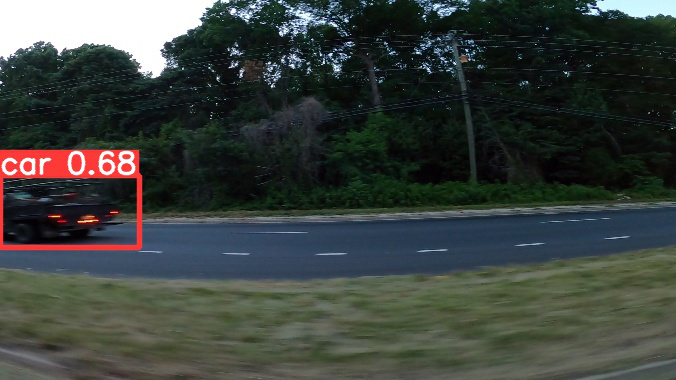

In [22]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')

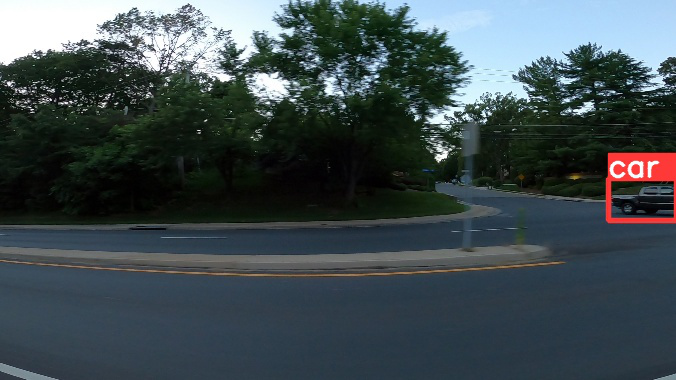

In [23]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')

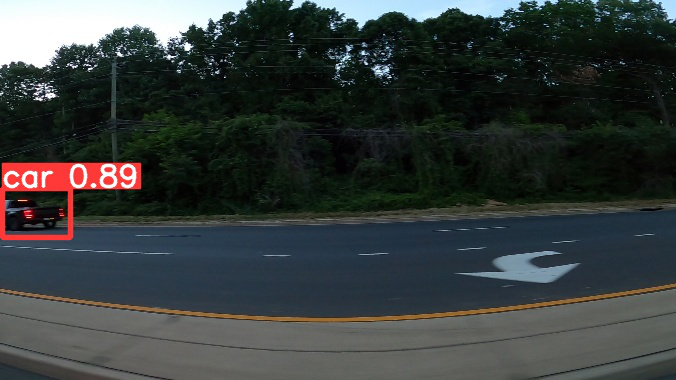

In [24]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')

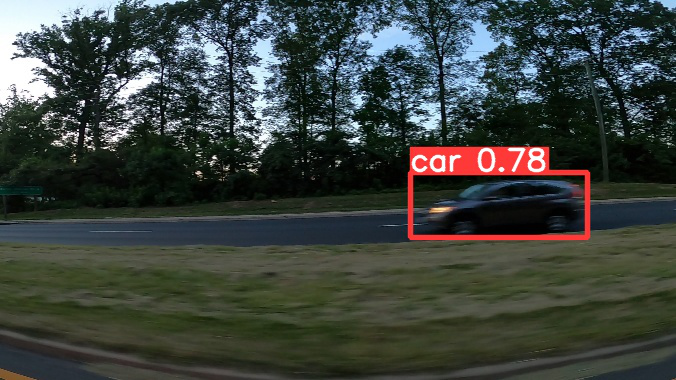

In [25]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')

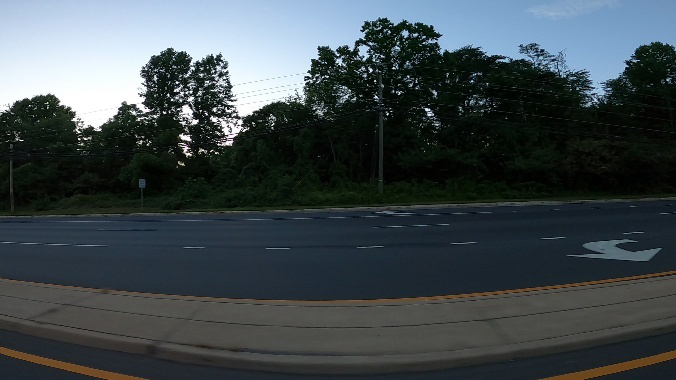

In [26]:
Image.open(f'./yolov5/runs/detect/exp/{random.choice(predicted_files)}')

In [27]:
!git clone https://github.com/ultralytics/yolov3  
!pip install -qr yolov3/requirements.txt 
!cp yolov3/requirements.txt ./

Cloning into 'yolov3'...
remote: Enumerating objects: 11833, done.
remote: Counting objects: 100% (1755/1755), done.
remote: Compressing objects: 100% (823/823), done.
remote: Total 11833 (delta 1260), reused 1324 (delta 931), pack-reused 10078 (from 1)
Receiving objects: 100% (11833/11833), 10.37 MiB | 18.18 MiB/s, done.
Resolving deltas: 100% (8059/8059), done.
ERROR: Could not find a version that satisfies the requirement numpy>=1.23.5 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0, 1.20.1, 

In [28]:
!python yolov3/detect.py --weights yolov3/yolov3.pt --img 676 --conf 0.5 --source /kaggle/input/car-object-detection/data/testing_images

detect: weights=['yolov3/yolov3.pt'], source=/kaggle/input/car-object-detection/data/testing_images, data=yolov3/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov3/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: Ultralytics requirements ['gitpython>=3.1.30', 'Pillow>=10.3.0'] not found, attempting AutoUpdate...
ERROR: Could not find a version that satisfies the requirement Pillow>=10.3.0 (from versions: 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7.0, 1.7.1, 1.7.2, 1.7.3, 1.7.4, 1.7.5, 1.7.6, 1.7.7, 1.7.8, 2.0.0, 2.1.0, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.3.2, 2.4.0, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.7.0, 2.8.0, 2.8.1, 2.8.2, 2.9.0, 3.0.0, 3.1.0rc1, 3.1.0, 3.1.1, 3.1.2,

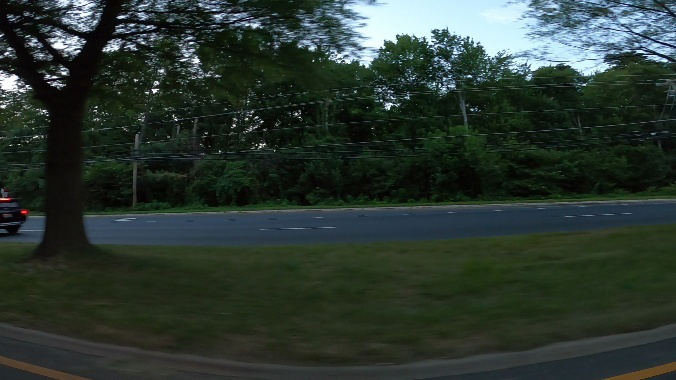

In [29]:
Image.open(f'./yolov3/runs/detect/exp/{random.choice(predicted_files)}')

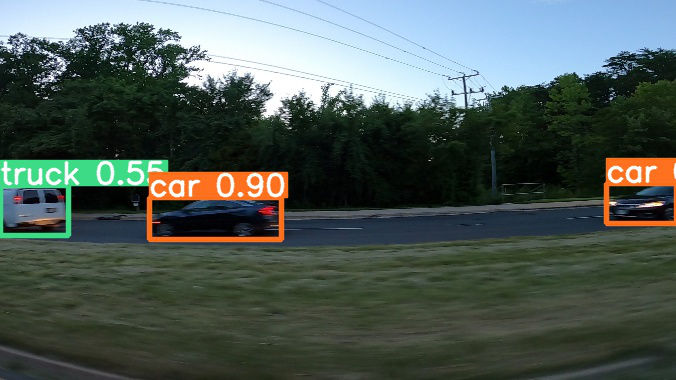

In [30]:
Image.open(f'./yolov3/runs/detect/exp/{random.choice(predicted_files)}')

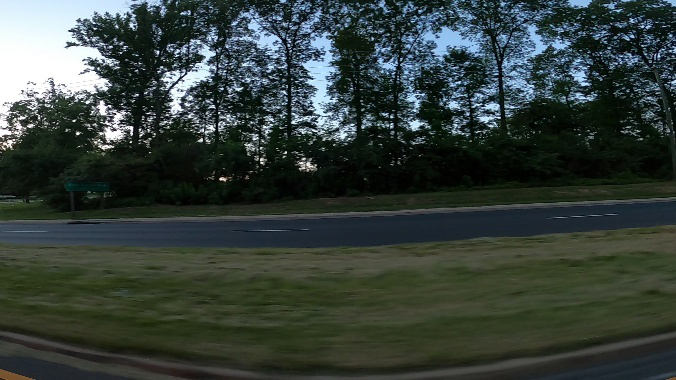

In [31]:
Image.open(f'./yolov3/runs/detect/exp/{random.choice(predicted_files)}')

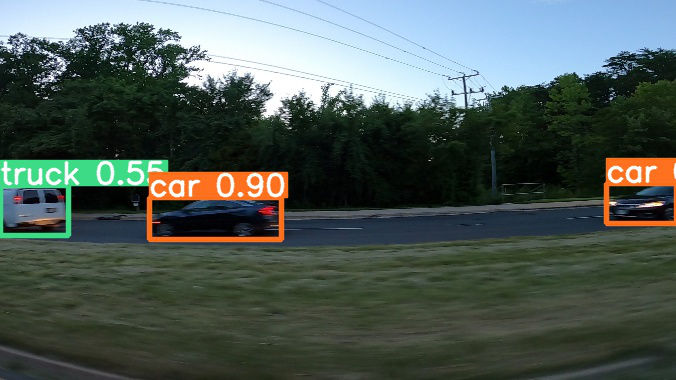

In [32]:
Image.open(f'./yolov3/runs/detect/exp/{random.choice(predicted_files)}')